In [1]:
import re
import numpy as np
import copy
import pickle
from collections import Counter
import random

from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords

import sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [2]:
class Traitement:
    def __init__(self, lowerCaps=True, stopWords=True, stemm=True):
        self.stopwords_list = set(stopwords.words('French'))
        self.stopWords = stopWords
        self.lowerCaps = lowerCaps
        self.stemm = stemm
        if self.lowerCaps==False and self.stemm==True:
            print("Warning: lowerCaps is mandatory with Stemmatization, lowerCaps=False will have no effect")
    
    def tokenize(self, text):
        stemmer = SnowballStemmer('french')
        tokens = word_tokenize(text)
        stems = [stemmer.stem(item) for item in tokens]
        return " ".join(stems)
    
    def removeStopWords(self, text):
        words = word_tokenize(text)
        wordsFiltered = []
        for w in words:
            if w not in self.stopwords_list:
                wordsFiltered.append(w)
        return " ".join(wordsFiltered)
    
    def processing(self, corpus):
        texts = copy.deepcopy(corpus)
        for i in range(len(texts)):
            #lower caps
            if self.lowerCaps:
                texts[i] = texts[i].lower()
            #removing stop words
            if self.stopWords:
                texts[i] = self.removeStopWords(texts[i])
            #stemming
            if self.stemm:
                texts[i] = self.tokenize(texts[i])
        return texts

In [3]:
file = open("AFDpresidentutf8/corpus.tache1.learn.utf8", "r",\
            encoding="utf-8")
fileArray = []
contenu = file.readline()
while contenu:
    ligne = re.findall(r"<[0-9]*:[0-9]*:(.)>(.*)", contenu, re.DOTALL)
    fileArray.append(ligne[0])
    contenu = file.readline()
fileArray = np.array(fileArray)

#------------------------------------------------
X_train_full = fileArray[:,1]
Y_train_full = np.where(fileArray[:,0]=='C',1,0)
#------------------------------------------------

ligneC=[]
ligneM=[]
for e in fileArray:
    if e[0]=='C':
        ligneC.append([e[0], e[1]])
    else:
        ligneM.append([e[0], e[1]])
np.random.shuffle(ligneC)

data_equilibre = np.array(ligneC[:len(ligneM)]+ligneM)
np.random.shuffle(data_equilibre)
#------------------------------------------------
X_train_equilibre = data_equilibre[:,1]
Y_train_equilibre = np.where(data_equilibre[:,0]=='C',1,0)
#------------------------------------------------

In [4]:
len(ligneC)/len(X_train_full)

0.8689669587027329

In [5]:
file = open("AFDpresidentutf8/corpus.tache1.test.utf8", "r",\
            encoding="utf-8")
X_test = []
contenu = file.readline()
while contenu:
    ligne = re.findall(r"<[0-9]*:[0-9]*>(.*)", contenu, re.DOTALL)
    X_test.append(ligne[0])
    contenu = file.readline()
X_test = np.array(X_test)

In [6]:
#traitement où on a enlevé les stopwords + stemmatizer
traitement = Traitement(lowerCaps=True, stopWords=False, stemm=True)

T_train_full = traitement.processing(X_train_full)
T_train_equilibre = traitement.processing(X_train_equilibre)
T_test  = traitement.processing(X_test)

In [7]:
print(X_train_full[0], T_train_full[0])

 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.
 quand je dis cher amis , il ne s'ag pas là d'un formul diplomat , mais de l'express de ce que je ressen .


# ------------------------------------------
## Classifieurs
# ------------------------------------------

In [14]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, make_scorer

def my_scoring(y, ypred):
    global scores
    scores['accuracy'].append(accuracy_score(y, ypred))
    scores['f1'].append(f1_score(y, ypred))
    return 0
my_scoring_ = make_scorer(my_scoring)

In [15]:
plotX = []
plotY=[[],[],[]]

In [16]:
plotX.append('MultinomialNB')
print(plotX[-1])
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
pipeline.fit(T_train_equilibre, Y_train_equilibre)

scores = {'accuracy':[],'f1':[]}
cross_val_score(pipeline, T_train_full, Y_train_full, cv=5, scoring=my_scoring_)
for k,v in scores.items():
    print(k,":",np.mean(v))
plotY[0].append(np.mean(scores['accuracy']))
plotY[1].append(np.mean(scores['f1']))
scores = cross_val_score(pipeline, T_train_full, Y_train_full, cv=5, scoring='roc_auc')
roc = sum(scores) / len(scores)
print("roc_auc:",roc)
plotY[2].append(roc)

MultinomialNB
accuracy : 0.8689669602844965
f1 : 0.9298901247122318
roc_auc: 0.7000531196996296


In [17]:
plotX.append('LinearSVC\nclass_weight={M:0.7, C:0.3}')
print(plotX[-1])
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC(class_weight={0:0.7, 1:0.3})),
])
pipeline.fit(T_train_equilibre, Y_train_equilibre)

scores = {'accuracy':[],'f1':[]}
cross_val_score(pipeline, T_train_full, Y_train_full, cv=5, scoring=my_scoring_)
for k,v in scores.items():
    print(k,":",np.mean(v))
plotY[0].append(np.mean(scores['accuracy']))
plotY[1].append(np.mean(scores['f1']))
scores = cross_val_score(pipeline, T_train_full, Y_train_full, cv=5, scoring='roc_auc')
roc = sum(scores) / len(scores)
print("roc_auc:",roc)
plotY[2].append(roc)

LinearSVC
class_weight={M:0.7, C:0.3}
accuracy : 0.9043072995844922
f1 : 0.945848050142138
roc_auc: 0.8847113392607158


In [18]:
plotX.append('DecisionTree')
print(plotX[-1])
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', DecisionTreeClassifier()),
])
pipeline.fit(T_train_equilibre, Y_train_equilibre)

scores = {'accuracy':[],'f1':[]}
cross_val_score(pipeline, T_train_equilibre, Y_train_equilibre, cv=5, scoring=my_scoring_)
for k,v in scores.items():
    print(k,":",np.mean(v))
plotY[0].append(np.mean(scores['accuracy']))
plotY[1].append(np.mean(scores['f1']))
scores = cross_val_score(pipeline, T_train_equilibre, Y_train_equilibre, cv=5, scoring='roc_auc')
roc = sum(scores) / len(scores)
print("roc_auc:",roc)
plotY[2].append(roc)

DecisionTree
accuracy : 0.6321283105279953
f1 : 0.6329557078948173
roc_auc: 0.6309981356471337


In [19]:
plotX.append('KNeighbors(k=3)')
print(plotX[-1])
pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()),
    ('clf', KNeighborsClassifier(3)),
])
pipeline.fit(T_train_equilibre, Y_train_equilibre)

scores = {'accuracy':[],'f1':[]}
cross_val_score(pipeline, T_train_full, Y_train_full, cv=5, scoring=my_scoring_)
for k,v in scores.items():
    print(k,":",np.mean(v))
plotY[0].append(np.mean(scores['accuracy']))
plotY[1].append(np.mean(scores['f1']))
scores = cross_val_score(pipeline, T_train_full, Y_train_full, cv=5, scoring='roc_auc')
roc = sum(scores) / len(scores)
print("roc_auc:",roc)
plotY[2].append(roc)

KNeighbors(k=3)
accuracy : 0.8688102037890566
f1 : 0.9297898864282155
roc_auc: 0.5047067710180322


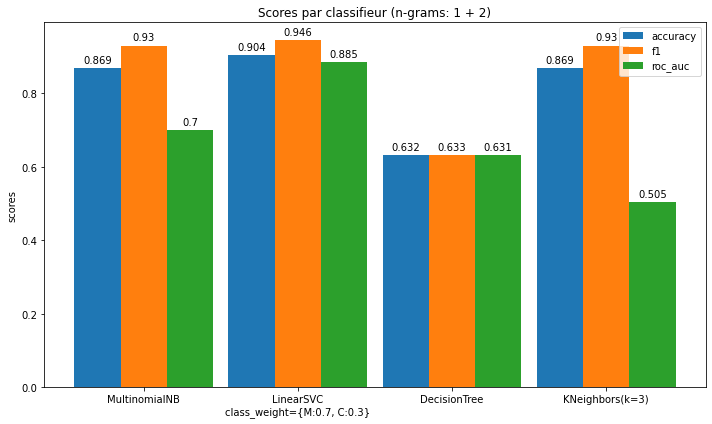

In [20]:
import numpy as np
import matplotlib.pyplot as plt
Xindices = np.arange(len(plotX))
width = 0.30

fig, ax = plt.subplots(figsize=(10, 6))
rect1 = ax.bar(Xindices, plotY[0], width, label='accuracy')
rect2 = ax.bar(Xindices+width, plotY[1], width, label='f1')
rect3 = ax.bar(Xindices+2*width, plotY[2], width, label='roc_auc')

ax.set_ylabel('scores')
ax.set_title('Scores par classifieur (n-grams: 1 + 2)')
ax.set_xticks(Xindices+width)
ax.set_xticklabels(plotX)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = round(rect.get_height(),3)
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rect1)
autolabel(rect2)
autolabel(rect3)
fig.tight_layout()
plt.show()

In [ ]:
def lissage(predictions, k, coef, nbTours):
    fenetre = (k-1)//2
    tabRes = []
    tabRes.append(predictions)
    
    for tour in range(nbTours):
        old = tabRes[-1]
        new = list(old[:fenetre])
        
        for i in range(fenetre,len(old)-fenetre):
            cnt = Counter(old[i-fenetre:i+fenetre+1])
            nbC = cnt[1]
            nbM = cnt[-1]
            if nbC > coef*nbM:
                new.append(1)
            else:
                new.append(-1)
        for j in range(fenetre):
            new.append(old[-(fenetre-j)])
        tabRes.append(new)
    
    for res in tabRes:
        cpt = Counter(res)
        print(cpt)
        
    return tabRes[-1]

In [ ]:
l = lissage(clf_predictions, 9, 2, 1)
l = lissage(l, 5, 1, 2)

In [ ]:
predictions_auteurs = open("predictions_auteurs2lissage2x.txt", "w")
#predict = np.where(clf_predictions==1,'C','M')
predict = np.where(np.array(l)==1,'C','M')
for v in predict:
    predictions_auteurs.write(v+"\n")
predictions_auteurs.close()

# ------------------------------------------
## Poubelle (ce qu'il y a en dessous ne sert à RIEN)
# ------------------------------------------

predictions_auteurs = open("predictions_auteurs.txt", "w")
predict = np.where(pipeline1.predict(T_test)==1,'C','M')
for res in predict:
    predictions_auteurs.write(res+"\n")
predictions_auteurs.close()

# ------------------------------------------
## 1ères Predictions + post-traitement
# ------------------------------------------